### Imports

In [ ]:
!pip install statsmodels==0.12.1

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

register_matplotlib_converters()
sns.set_style('darkgrid')

In [3]:
plt.rc("figure", figsize=(16,12))
plt.rc("font", size=13)

### Data: Atlantic Meridional Mode (AMM)

The `AMM` spatial pattern is defined via applying Maximum Covariance Analysis (MCA) to sea surface temperature and the zonal and meridional components of the 10m wind field over the time period 1950-2005, from the NCEP/NCAR Reanalysis.

The mode describes the meridional variabilty in the tropical Atlantic Ocean. 


In [4]:
amm_pd = pd.read_csv('Atlantic Meridional Mode.csv', index_col='Year').dropna()
amm = amm_pd.to_numpy().flatten() # obtain a vector of all the csv data
amm = amm[:-9]                    # remove missing entries from april to dec 2022
year = int(amm_pd.index[0])       # get initial year of data 
AMM = pd.Series(
    amm, 
    index=pd.date_range("1-1-{}".format(year), periods=len(amm), freq='M'),
    name='Atlantic Meridional Mode'
)
AMM.describe()

count    891.000000
mean       0.193187
std        2.510719
min       -6.820000
25%       -1.405000
50%        0.210000
75%        1.920000
max        8.230000
Name: Atlantic Meridional Mode, dtype: float64

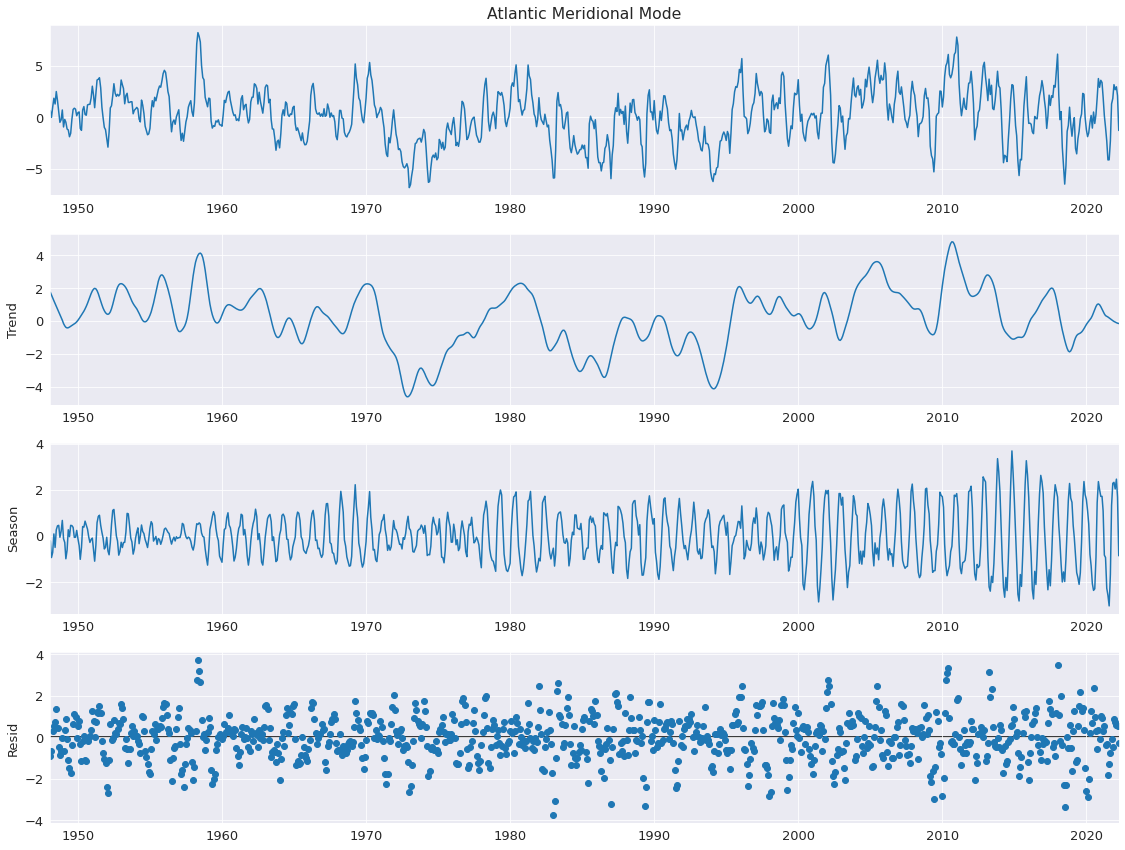

In [8]:
stl = STL(AMM, period=12)
res = stl.fit()
fig = res.plot()

### Robust Fitting

Here we are estimating the model with and without robust weighting. The biggest difference is at the end of the 50's and 90's decades. The non-robust estimate places equal weights on all observations. The weights vary betwen 0 and 1. 

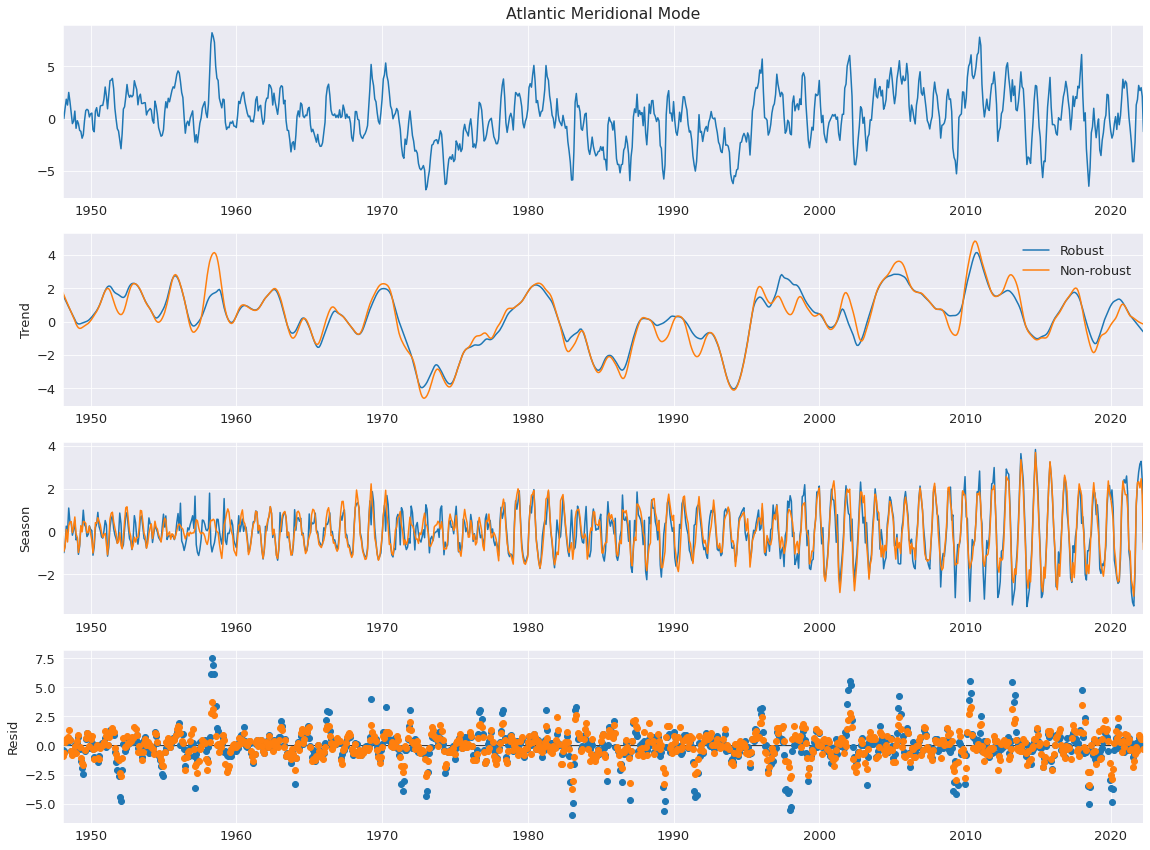

In [7]:
def add_STL_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


stl = STL(AMM, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(AMM, period=12, robust=False).fit()
add_STL_plot(fig, res_non_robust, ["Robust", "Non-robust"])

### LOESS degree

The default configuration estimates the LOESS model with both a constant and a trend. This can be changed to only include a constant by setting `COMPONENT_deg` to 0. Here the degree makes little difference as we can see in the Trend and Season plot.

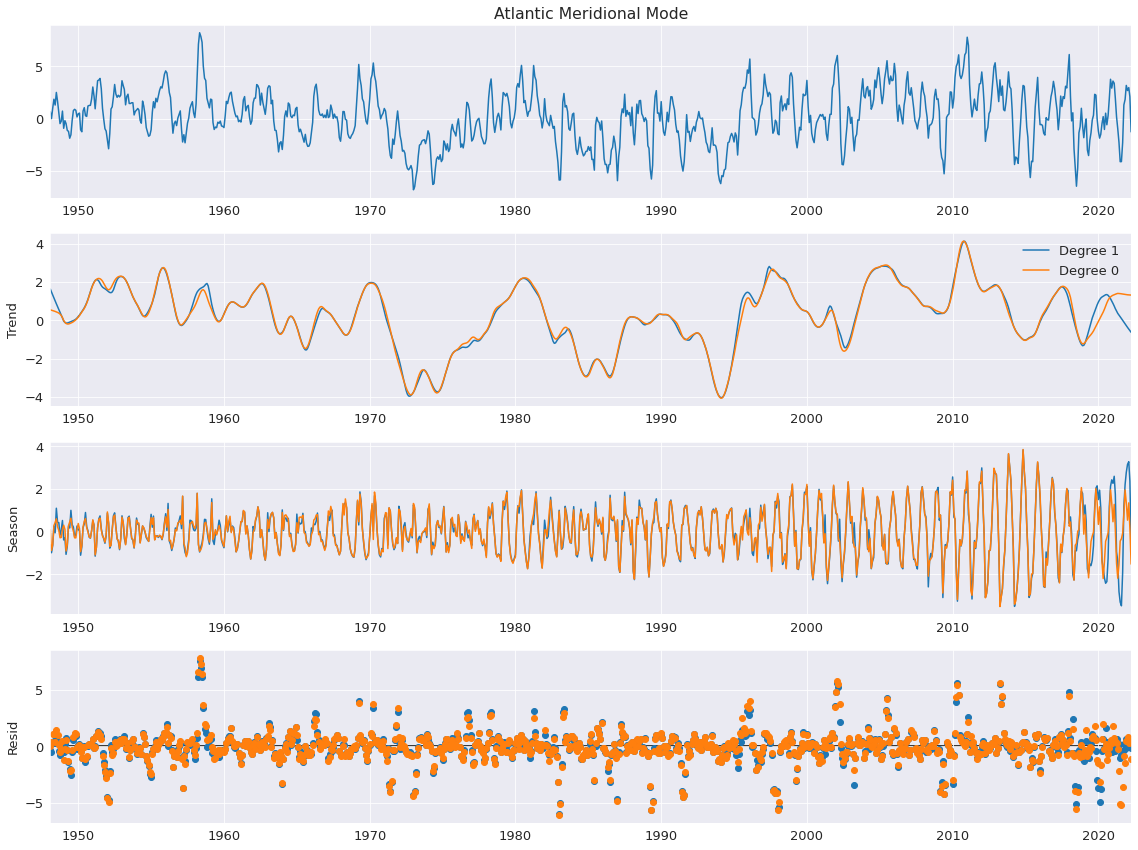

In [9]:
stl = STL(
    AMM, period=12, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True
)
res_deg_0 = stl.fit()
fig = res_robust.plot()
add_STL_plot(fig, res_deg_0, ["Degree 1", "Degree 0"])

### Forecasting with STL

Here we are forecasting the AMM values for 21 periods which is the equivalent of inferring the values for the remaining months of 2022 and the full year of 2023.

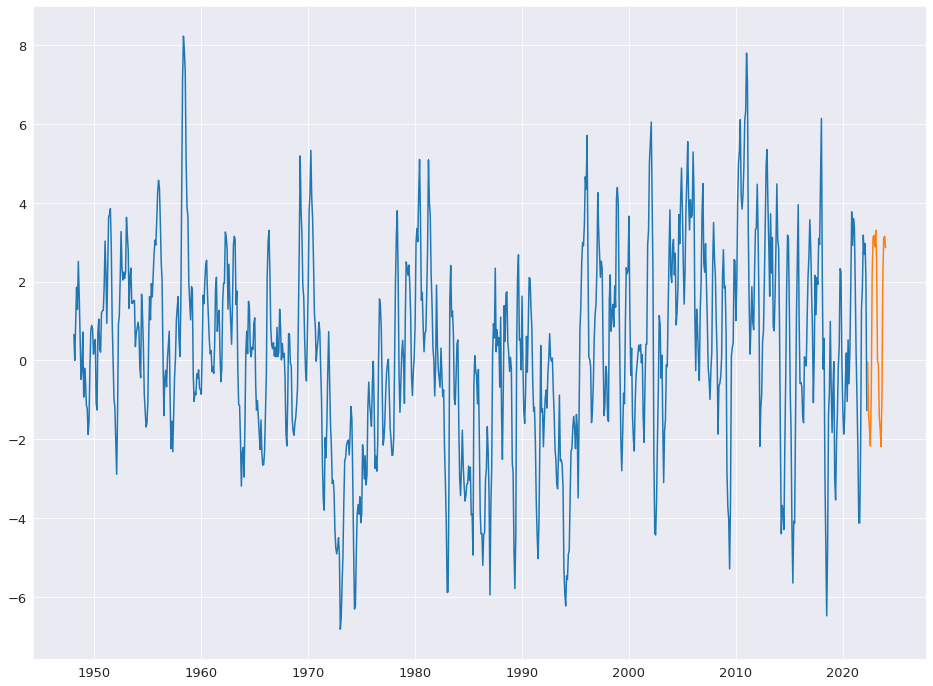

In [16]:
stlf = STLForecast(AMM, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(21)
plt.plot(AMM)
plt.plot(forecast)
plt.show()

As a comparison test we can observe how precise is the ARIMA(1,1,0) model in forecasting future values. Here we are eliminating the last 50 values of `AMM` and comparing how well does the ARIMA model predict them compared to the real values. We can observe that the ARIMA model is good at capturing the seasonality of the data but it fails at identifying possible spikes such as the -4 value in June 2021. 

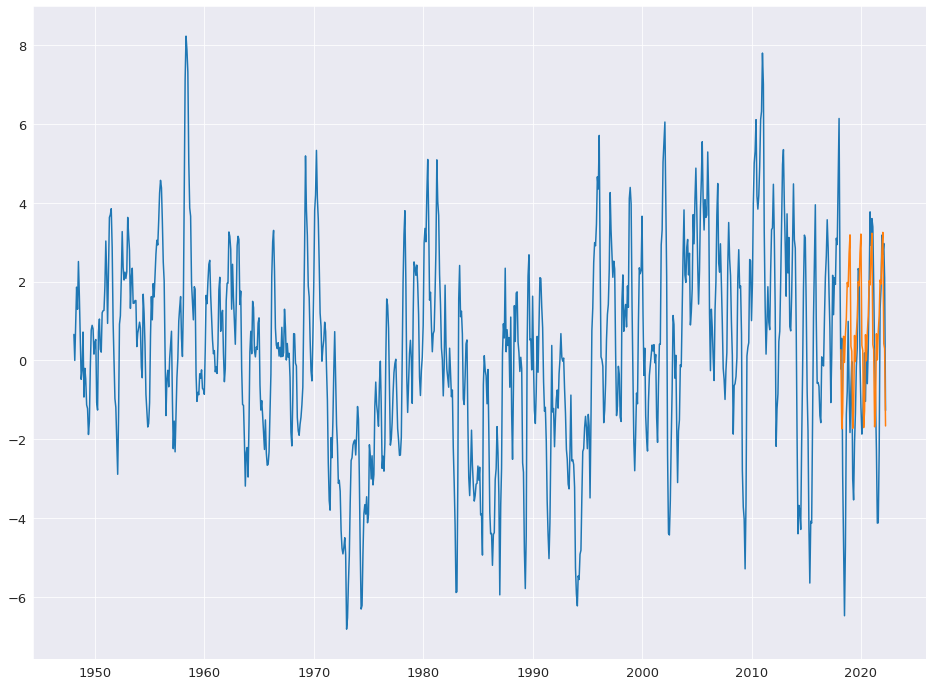

In [17]:
stlf = STLForecast(AMM[:-50], ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(50)
plt.plot(AMM)
plt.plot(forecast)
plt.show()